# The Red Line Problem

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

The Red Line is a subway that connects Cambridge and Boston, Massachusetts. When I was working in Cambridge I took the Red Line from Kendall Square to South Station and caught the commuter rail to Needham. During rush hour Red Line trains run every 7–8 minutes, on average.

When I arrived at the station, I could estimate the time until the next train based on the number of passengers on the platform. If there were only a few people, I inferred that I just missed a train and expected to wait about 7 minutes. If there were more passengers, I expected the train to arrive sooner. But if there were a large number of passengers, I suspected that trains were not running on schedule, so I would go back to the street level and get a taxi.

While I was waiting for trains, I thought about how Bayesian estimation could help predict my wait time and decide when I should give up and take a taxi. This chapter presents the analysis I came up with.

This example is based on a project by Brendan Ritter and Kai Austin, who took a class with me at Olin College.
It was a chapter in the first edition of *Think Bayes*, I cut it from the second edition.

Before we get to the analysis, we have to make some modeling decisions. First, I will treat passenger arrivals as a Poisson process, which means I assume that passengers are equally likely to arrive at any time, and that they arrive at a rate, λ, measured in passengers per minute. Since I observe passengers during a short period of time, and at the same time every day, I assume that λ is constant.

On the other hand, the arrival process for trains is not Poisson. Trains to Boston are supposed to leave from the end of the line (Alewife station) every 7–8 minutes during peak times, but by the time they get to Kendall Square, the time between trains varies between 3 and 12 minutes.

To gather data on the time between trains, I wrote a script that downloads real-time data from the [MBTA](http://www.mbta.com/rider_tools/developers/), selects south-bound trains arriving at Kendall square, and records their arrival times in a database. I ran the script from 4 pm to 6 pm every weekday for 5 days, and recorded about 15 arrivals per day. Then I computed the time between consecutive arrivals.
Here are the gap times I recorded, in seconds.

In [4]:
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

I'll convert them to minutes and use `kde_from_sample` to estimate the distribution.

In [5]:
import numpy as np

zs = np.array(observed_gap_times) / 60

In [6]:
from utils import kde_from_sample

qs = np.linspace(0, 20, 101)
pmf_z = kde_from_sample(zs, qs)

Here's what it looks like.

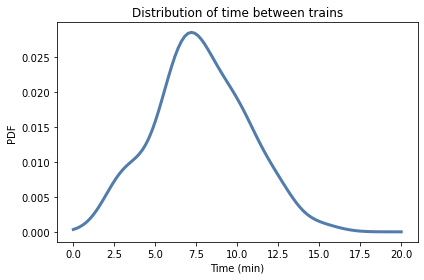

In [7]:
from utils import decorate

pmf_z.plot()

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

## The Update

At this point we have an estimate for the distribution of time between trains.
Now let's suppose I arrive at the station and see 10 passengers on the platform.
What distribution of wait times should I expect?

We'll answer this question in two steps.

* First, we'll derive the distribution of gap times as observed by a random arrival (me).

* Then we'll derive the distribution of wait times, conditioned on the number of passengers.

When I arrive at the station, I am more likely to arrive during a long gap than a short one.
In fact, the probability that I arrive during any interval is proportional to its duration.

If we think of `pmf_z` as the prior distribution of gap time, we can do a Bayesian update to compute the posterior.
The likelihood of my arrival during each gap is the duration of the gap:

In [8]:
likelihood = pmf_z.qs

So here's the first update.

In [9]:
posterior_z = pmf_z * pmf_z.qs
posterior_z.normalize()

7.772927524715933

Here's what the posterior distribution looks like.

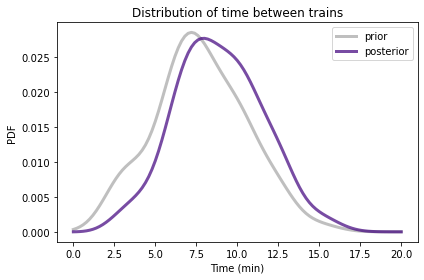

In [10]:
pmf_z.plot(label='prior', color='C5')
posterior_z.plot(label='posterior', color='C4')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

Because I am more likely to arrive during a longer gap, the distribution is shifted to the right.
The prior mean is about 7.8 minutes; the posterior mean is about 8.9 minutes.

In [11]:
pmf_z.mean(), posterior_z.mean()

(7.772927524715933, 8.89677416786441)

This shift is an example of the "inspection paradox", which [I wrote an article about](https://towardsdatascience.com/the-inspection-paradox-is-everywhere-2ef1c2e9d709).

As an aside, the Red Line schedule reports that trains run every 9 minutes during peak times. This is close to the posterior mean, but higher than the prior mean. I exchanged email with a representative of the MBTA, who confirmed that the reported time between trains is deliberately conservative in order to account for variability.

## Elapsed time

Elapsed time, which I call `x`, is the time between the arrival of the previous train and the arrival of a passenger. 
Wait time, which I call `y`, is the time between the arrival of a passenger and the next arrival of a train. 
I chose this notation so that 

```
z = x + y.
```

Given the distribution of `z`, we can compute the distribution of `y`. I’ll start with a simple case and then generalize. Suppose the gap between trains is either 5 or 10 minutes with equal probability.

If we arrive at a random time, we arrive during a 5 minute gap with probability 1/3, or a 10 minute gap with probability 2/3.

If we arrive during a 5 minute gap, `x` is uniform from 0 to 5 minutes. If we arrive during a 10 minute gap, `x` is uniform from 0 to 10. 
So the distribution of wait times is a weighted mixture of two uniform distributions.

More generally, if we have the posterior distribution of `z`, we can compute the distribution of `x` by making a mixture of uniform distributions.
We'll use the following function to make the uniform distributions.

In [12]:
from empiricaldist import Pmf

def make_dist_wait(gap, qs):
    qs = qs[qs <= gap]
    n = len(qs)
    return Pmf(1/n, qs)

`make_dist_wait` takes a hypothetical gap and an array of wait times.
It selects the wait times less than or equal to `gap` and puts them into a `Pmf` that represents a uniform distribution.

I'll use this function to make a sequence of `Pmf` objects, one for each gap in `posterior_z`.

In [13]:
qs = posterior_z.qs
pmf_seq = [make_dist_wait(gap, qs) for gap in qs]

Here's an example that represents a uniform distribution from 0 to 0.6 minutes.

In [14]:
pmf_seq[3]

,probs
0.0,0.25
0.2,0.25
0.4,0.25
0.6,0.25


The last element of the sequence is uniform from 0 to 20 minutes.

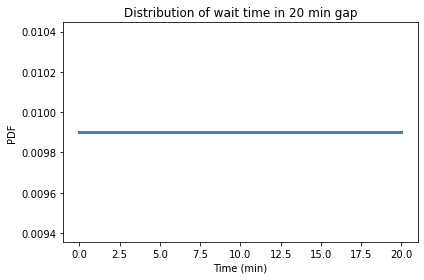

In [15]:
pmf_seq[-1].plot()

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of wait time in 20 min gap')

Now we can use `make_mixture` to make a weighted mixture of uniform distributions, where the weights are the probabilities from `posterior_z`.

In [16]:
from utils import make_mixture

pmf_x = make_mixture(posterior_z, pmf_seq)

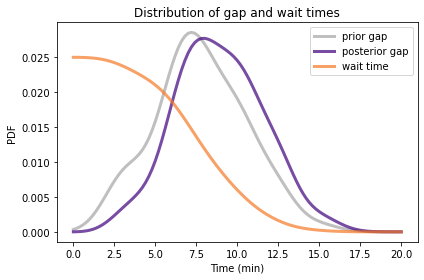

In [17]:
pmf_z.plot(label='prior gap', color='C5')
posterior_z.plot(label='posterior gap', color='C4')
pmf_x.plot(label='wait time', color='C1')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of gap and wait times')

In [18]:
posterior_z.mean(), pmf_x.mean()

(8.89677416786441, 4.448387083932206)

The mean wait time is 4.4 minutes, half the posterior mean of `z`.
And that makes sense, since we expect to wait half the duration of the gap, on average.

## Counting passengers

Now let's take into account the number of passengers waiting on the platform.
Let's assume that passengers are equally likely to arrive at any time, and that they arrive at a rate, `λ`, that is known to be 2 passengers per minute.

Under those assumptions, the number of passengers who arrive in `x` minutes follows a Poisson distribution with parameter `λ x`
So we can use the SciPy function `poisson` to compute the likelihood of 10 passengers for each possible value of `x`.

In [19]:
from scipy.stats import poisson

lam = 2
num_passengers = 10
likelihood = poisson(lam * pmf_x.qs).pmf(num_passengers)

With this likelihood, we can compute the posterior distribution of `x`.

In [20]:
posterior_x = pmf_x * likelihood
posterior_x.normalize()

0.04757676716097805

Here's what it looks like:

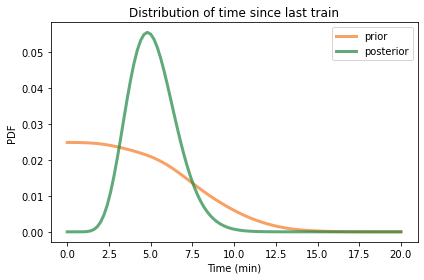

In [21]:
pmf_x.plot(label='prior', color='C1')
posterior_x.plot(label='posterior', color='C2')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time since last train')

Based on the number of passengers, we think it has been about 5 minutes since the last train.

In [22]:
pmf_x.mean(), posterior_x.mean()

(4.448387083932206, 5.1439350761797495)

## Wait time

Now how long do we think it will be until the next train?
Based on what we know so far, the distribution of `z` is `posterior_z`, and the distribution of `x` is `posterior_x`.
Remember that we defined

```
z = x + y
```

If we know `x` and `z`, we can compute

```
y = z - x
```

So we can use `sub_dist` to compute the distribution of `y`.

In [23]:
posterior_y = Pmf.sub_dist(posterior_z, posterior_x)

Well, almost.  That distribution contains some negative values, which are impossible.
But we can remove them and renormalize, like this:

In [24]:
nonneg = (posterior_y.qs >= 0)
posterior_y = Pmf(posterior_y[nonneg])
posterior_y.normalize()

0.8900343090047254

Based on the information so far, here are the distributions for `x`, `y`, and `z`, shown as CDFs.

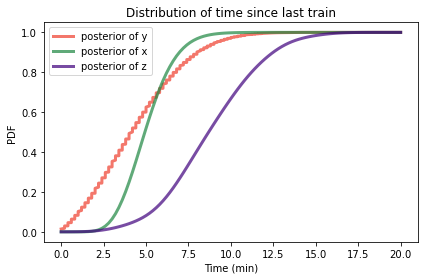

In [25]:
posterior_y.make_cdf().plot(label='posterior of y', color='C3')
posterior_x.make_cdf().plot(label='posterior of x', color='C2')
posterior_z.make_cdf().plot(label='posterior of z', color='C4')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time since last train')

Because of rounding errors, `posterior_y` contains quantities that are not in `posterior_x` and `posterior_z`; that's why I plotted it as a CDF, and why it appears jaggy.

## Decision analysis

At this point we can use the number of passengers on the platform to predict the distribution of wait times. Now let’s get to the second part of the question: when should I stop waiting for the train and go catch a taxi?

Remember that in the original scenario, I am trying to get to South Station to catch the commuter rail. Suppose I leave the office with enough time that I can wait 15 minutes and still make my connection at South Station.

In that case I would like to know the probability that `y` exceeds 15 minutes as a function of `num_passengers`.
To answer that question, we can run the analysis from the previous section with range of `num_passengers`.

But there’s a problem. The analysis is sensitive to the frequency of long delays, and because long delays are rare, it is hard to estimate their frequency.

I only have data from one week, and the longest delay I observed was 15 minutes. So I can’t estimate the frequency of longer delays accurately.

However, I can use previous observations to make at least a coarse estimate. When I commuted by Red Line for a year, I saw three long delays caused by a signaling problem, a power outage, and “police activity” at another stop. So I estimate that there are about 3 major delays per year.

But remember that my observations are biased. I am more likely to observe long delays because they affect a large number of passengers. So we should treat my observations as a sample of `posterior_z` rather than `pmf_z`.

Here's how we can augment the observed distribution of gap times with some assumptions about long delays.
From `posterior_z`, I'll draw a sample of 260 values (roughly the number of work days in a year).
Then I'll add in delays of 30, 40, and 50 minutes (the number of long delays I observed in a year).

In [26]:
sample = posterior_z.sample(260)
delays = [30, 40, 50]
augmented_sample = np.append(sample, delays)

I'll use this augmented sample to make a new estimate for the posterior distribution of `z`.

In [27]:
qs = np.linspace(0, 60, 101)
augmented_posterior_z = kde_from_sample(augmented_sample, qs)

Here's what it looks like.

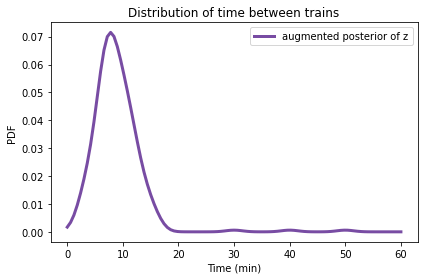

In [28]:
augmented_posterior_z.plot(label='augmented posterior of z', color='C4')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

Now let's take the analysis from the previous sections and wrap it in a function.

In [29]:
qs = augmented_posterior_z.qs
pmf_seq = [make_dist_wait(gap, qs) for gap in qs]
pmf_x = make_mixture(augmented_posterior_z, pmf_seq)
lam = 2
num_passengers = 10

def compute_posterior_y(num_passengers):   
    """Distribution of wait time based on `num_passengers`."""
    likelihood = poisson(lam * qs).pmf(num_passengers)
    posterior_x = pmf_x * likelihood
    posterior_x.normalize()
    posterior_y = Pmf.sub_dist(augmented_posterior_z, posterior_x)
    nonneg = (posterior_y.qs >= 0)
    posterior_y = Pmf(posterior_y[nonneg])
    posterior_y.normalize()
    return posterior_y

Given the number of passengers when we arrive at the station, it computes the posterior distribution of `y`.
As an example, here's the distribution of wait time if we see 10 passengers.

In [30]:
posterior_y = compute_posterior_y(10)

We can use it to compute the mean wait time and the probability of waiting more than 15 minutes.

In [31]:
posterior_y.mean()

4.858287809432188

In [32]:
1 - posterior_y.make_cdf()(15)

0.013776790629149716

If we see 10 passengers, we expect to wait a little less than 5 minutes, and the chance of waiting more than 15 minutes is about 1%.

Let's see what happens if we sweep through a range of values for `num_passengers`.

In [33]:
nums = np.arange(0, 37, 3)
posteriors = [compute_posterior_y(num) for num in nums]

Here's the mean wait as a function of the number of passengers.

In [34]:
mean_wait = [posterior_y.mean()
             for posterior_y in posteriors]

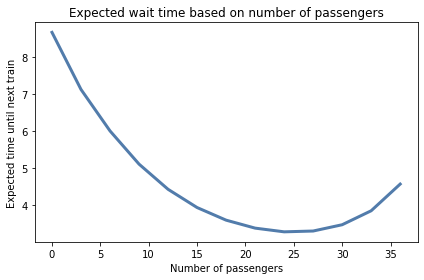

In [35]:
import matplotlib.pyplot as plt

plt.plot(nums, mean_wait)

decorate(xlabel='Number of passengers',
         ylabel='Expected time until next train',
         title='Expected wait time based on number of passengers')

If there are no passengers on the platform when I arrive, I infer that I just missed a train; in that case, the expected wait time is the mean of `augmented_posterior_z`.

The more passengers I see, the longer I think it has been since the last train, and the more likely a train arrives soon.

But only up to a point.  If there are more than 30 passengers on the platform, that suggests that there is a long delay, and the expected wait time starts to increase.

Now here's the probability that wait time exceeds 15 minutes.

In [36]:
prob_late = [1 - posterior_y.make_cdf()(15) 
             for posterior_y in posteriors]

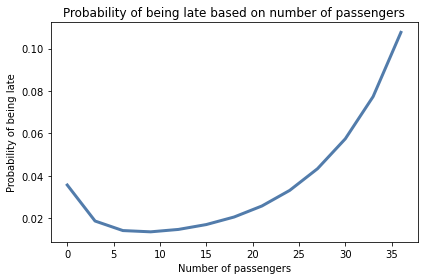

In [38]:
plt.plot(nums, prob_late)

decorate(xlabel='Number of passengers',
         ylabel='Probability of being late',
         title='Probability of being late based on number of passengers')

When the number of passengers is less than 20, we infer that the system is operating normally, so the probability of a long delay is small. If there are 30 passengers, we suspect that something is wrong and expect longer delays.

If we are willing to accept a 5% chance of missing the connection at South Station, we should stay and wait as long as there are fewer than 30 passengers, and take a taxi if there are more.

Or, to take this analysis one step further, we could quantify the cost of missing the connection and the cost of taking a taxi, then choose the threshold that minimizes expected cost.

This analysis is based on the assumption that the arrival rate, `lam`, is known.
If it is not know precisely, but is estimated from data, we could represent our uncertainty about `lam` with a distribution, compute the distribution of `y` for each value of `lam`, and make a mixture to represent the distribution of `y`.
I did that in the version of this problem in the first edition of *Think Bayes*; I left it out here because it is not the focus of the problem.
